In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint as sp_randint
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

dfs = {}
for file in ['../data/MovAve15_Data.csv', '../data/MovAve30_Data.csv',
             '../data/MovAve60_Data.csv', '../data/MovAve90_Data.csv']:
    dfs[file[14:16]] = pd.read_csv(file)

In [10]:
#for df in dfs.values():
#    df.drop(['elo_home', 'elo_away'], axis=1, inplace=True)

In [12]:
class CustomKFold:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def split(self, df, y, groups=None):
        from sklearn.model_selection import StratifiedKFold
        import numpy as np

        sk = StratifiedKFold(random_state=0, n_splits=self.n_splits, shuffle=True)

        train_all = df[df['year'] < 2019]

        for train_idx, valid_idx in sk.split(np.zeros(train_all.shape[0]), train_all['year']):
            yield (train_idx, valid_idx)

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

# cross_validate_by_year(your_classifier_with_parameters_set, df) 
        
# after you're done modeling and have the `best_estimator`, uncomment the following lines and run them
# best_predictions = best_estimator.predict_proba(test.drop('Target_Var', axis=1))
# test_actuals = test['Target_Var']

# compare the `test_actuals` with the `best_predictions`

# with open('best_estimator_{}'.format(moving_average_setting), 'wb') as f:
#     pickle.dump(best_estimator, f, protocol=-1)

In [14]:
def find_best_cols(x_train, y_train):
    gb = GradientBoostingClassifier(random_state=0, max_features='log2', n_iter_no_change=10000)

    params = {'n_estimators': sp_randint(10, 1000),
              'max_depth': sp_randint(2, 6),
              'loss': ['deviance', 'exponential'],
              'min_samples_leaf': sp_randint(2, 10),
              }

    cols = x_train.columns
    n_iter = 0

    while len(cols) > 30:
        print('iteration {}'.format(n_iter))
        cv = RandomizedSearchCV(gb,
                                params,
                                n_iter=20,
                                cv=CustomKFold(),
                                scoring='roc_auc',
                                random_state=0,
                                n_jobs=-1,
                                )
        print('fitting')
        cv.fit(x_train[cols], y_train)
        fi = [x for x in zip(x_train[cols].columns, cv.best_estimator_.feature_importances_)]
        fi.sort(key=lambda x: x[1], reverse=True)
        if fi[-1][0] != 'year':
            fi = fi[:-1]
        else:
            fi = fi[:-2] + fi[-1]
        cols = [col for col, imp in fi]
        if 'year' not in cols:
            fi = fi[:-1]
            cols = [col for col, imp in fi]
            cols.append('year')
        n_iter += 1
    return cols

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


best estimator accuracy for 15: 0.5202


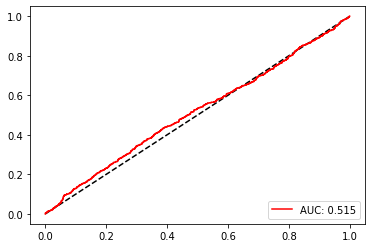

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


best estimator accuracy for 30: 0.5113


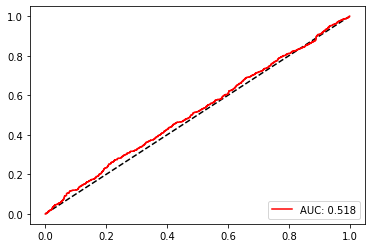

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


best estimator accuracy for 60: 0.4959


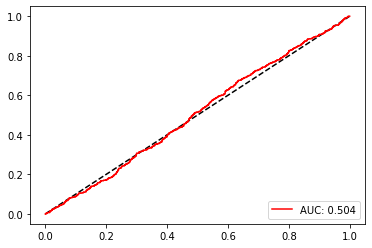

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


best estimator accuracy for 90: 0.5008


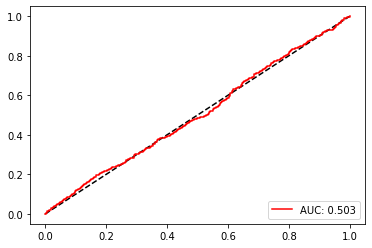

In [15]:
for name, df in dfs.items():
    train = df[df['year'] < 2019]
    test = df[df['year'] == 2019]

    x_train = train.drop(['Target_Var'], axis=1)
    y_train = train['Target_Var']

    x_test = test.drop(['Target_Var'], axis=1)
    y_test = test['Target_Var']
    
    cols = find_best_cols(x_train, y_train)

    gb = GradientBoostingClassifier(random_state=0, n_iter_no_change=10000)

    params = {'n_estimators': sp_randint(10, 1000),
              'max_depth': sp_randint(2, 6),
              'loss': ['deviance', 'exponential'],
              'min_samples_leaf': sp_randint(2, 10),
              }

    cv = RandomizedSearchCV(gb,
                            params,
                            n_iter=100,
                            cv=CustomKFold(),
                            scoring='roc_auc',
                            random_state=0,
                            n_jobs=-1,
                            verbose=1,
                            )
    cv.fit(x_train[cols], y_train)

    print('best estimator accuracy for {}: {:.4f}'.format(name, cv.best_estimator_.score(x_test[cols], y_test)))

    fpr, tpr, thresholds = roc_curve(y_test, cv.best_estimator_.predict_proba(x_test[cols])[:,1])
    best_auc = auc(fpr, tpr)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, 'r', label='AUC: {:.3f}'.format(best_auc))
    plt.legend(loc='lower right')
    plt.show()
    
    with open('cols_{}.pckl'.format(name, 'wb')) as f:
        pickle.dump(cols, f)
    with open('best_gb_model_{}.pckl'.format(name), 'wb') as f:
        pickle.dump(cv.best_estimator_, f)
    with open('best_gb_model_cv_{}.pckl'.format(name), 'wb') as f:
        pickle.dump(cv, f)